In [62]:
#Loading the Boston housing dataset
#The targets are the median values of owner-occupied homes, in thousands of dollars
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [63]:
#Printing the shape of train and test data
print("The shape of train_data is" + ' ' + str(train_data.shape) + '.')
print("The shape of test_data is" + ' ' + str(test_data.shape) + '.')

The shape of train_data is (404, 13).
The shape of test_data is (102, 13).


In [64]:
#Preparing the data
#Each column in the input data represents one of the 13 features, for example crime rate
#We do feature-wise normalization, i.e. for each feature we subtract the mean of the feature and divide by
#the standard deviation, s.t. the feature is centered around 0 and has a unit standard deviation

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

#Normalizing the test data, never use any quantity computed in the test data in the workflow
test_data -= mean
test_data /= std

In [70]:
#Building the network
#We have very few samples and thus use a very small network with two hidden layers, each with 64 units
#In general: the less training data, the worse overfitting will be
#A small network is one way to mitigate overfitting
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model(): #We need to instantiate the same model multiple times and thus define a function
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) #single unit and no activation, i.e. linear layer
                               #typical setup for scalar regression
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) #mse mean squared error widely used for regression 
                                                                    #problems
                                                                    #mae mean absolute error is the absolute value
                                                                    #of the difference between the predictions and 
                                                                    #targets
    return model

In [71]:
#K-fold validation
#As the dataset is to small to split up into a training and validation set, we use K-fold cross-validation
#Details can be found in DL with Python p.87
import numpy as np

k = 4
num_val_samples = len(train_data) // k #a//b is a divided by b, rounded to the next smallest whole number
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples] #validation data from partition #k
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i+1)*num_val_samples:]],
                                        axis=0)                         #train data, data from all other partitions
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                            train_targets[(i+1)*num_val_samples:]],axis=0)
    model  = build_model()
    #training the model in silent mode, i.e. verbose=0
    model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1, verbose = 0)
    #evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [72]:
all_scores

[2.4351282, 2.4362144, 2.6554637, 2.4722338]

In [73]:
np.mean(all_scores)

2.4997602

In [75]:
#Training with more epochs with saving the per epoch validation score log
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples] #validation data from partition #k
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i+1)*num_val_samples:]],
                                        axis=0)                         #train data, data from all other partitions
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                            train_targets[(i+1)*num_val_samples:]],axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs = num_epochs, batch_size = 1, verbose = 0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [76]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

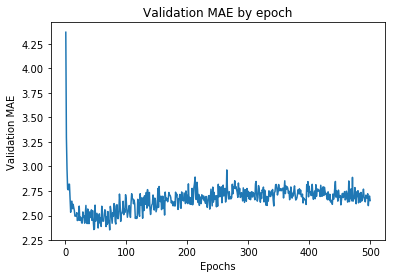

In [85]:
#Plotting validation scores
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.title('Validation MAE by epoch')
plt.show()

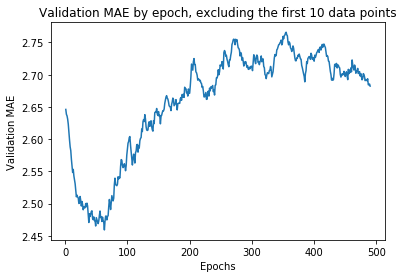

In [97]:
#As we can't really see the plot, we omit the first 10 data points since they are on a different scale than the rest
#To obtain a smooth curve we replace each point with an exponential moving average of the previous points
def smooth_curve(points, factor = 0.9):
    smoothed_points = [points[0]]
    for point in points[1:]:
        previous = smoothed_points[-1]
        smoothed_points.append(previous * factor + point * (1 - factor))
 
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.title('Validation MAE by epoch, excluding the first 10 data points')
plt.show()

In [98]:
#Training a final model with 80 epochs, since the model is overfitting after 80 epochs
mode = build_model() #get a fresh compiled model
model.fit(train_data, train_targets, epochs = 80, batch_size=16, verbose=0) #training on the entire data
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 55us/sample - loss: 11.1228 - mae: 2.3473


In [99]:
test_mae_score

2.347349